In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yoyobun1","key":"6069260cd11ceca25354644b44ba0da5"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
 97% 1.18G/1.21G [00:09<00:00, 197MB/s]
100% 1.21G/1.21G [00:09<00:00, 131MB/s]


In [4]:
!unzip gtzan-dataset-music-genre-classification.zip

Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues.00014.wa

## Importing Libraries

In [5]:
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam

In [6]:
random_file_name = "Data/genres_original/blues/blues.00000.wav"

Text(0.5, 1.0, 'Waveform of the Audio File')

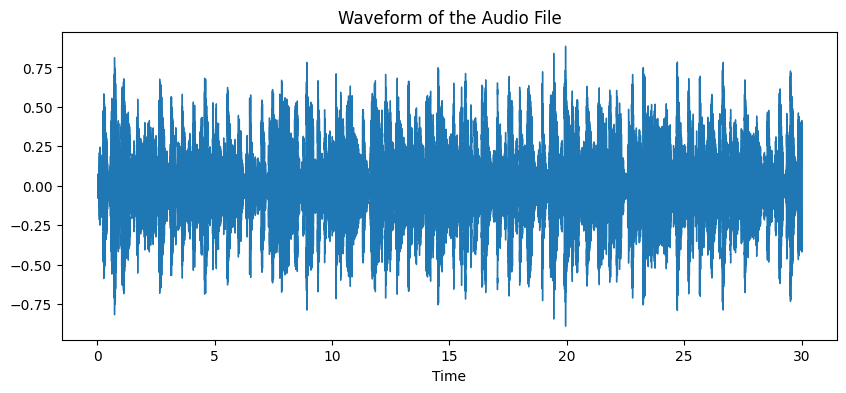

In [7]:
s, sr = librosa.load(random_file_name, sr=44100)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(s, sr=sr)
plt.title("Waveform of the Audio File")

In [8]:
s.shape

(1323588,)

In [9]:
s

array([ 0.00734921,  0.01335782,  0.01657648, ..., -0.07293833,
       -0.06308185, -0.03151622], dtype=float32)

## Visualizing Chunks of Audio

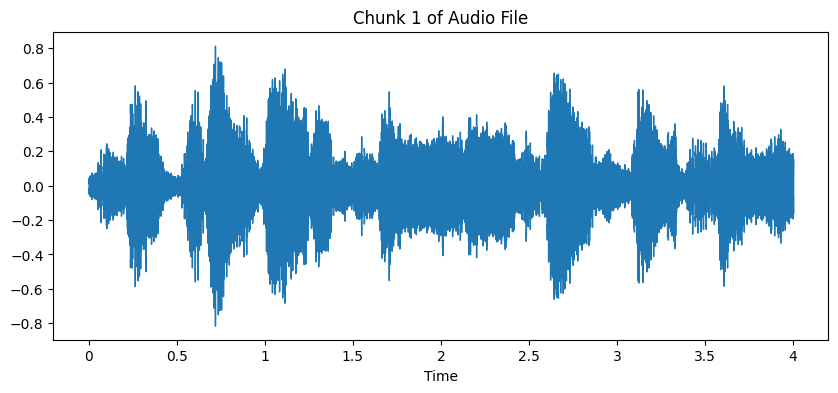

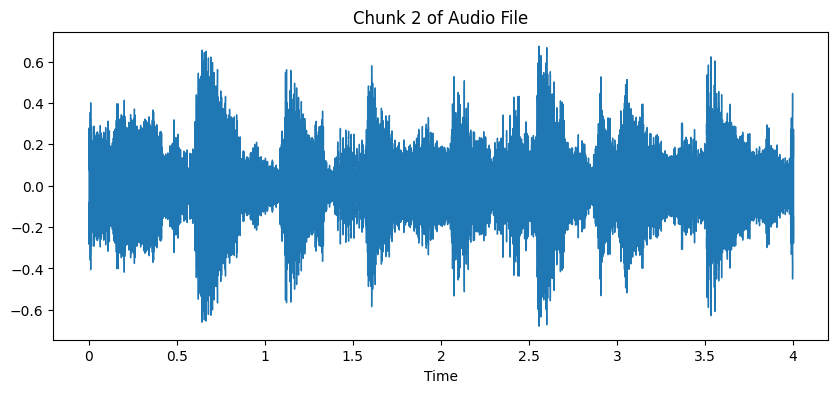

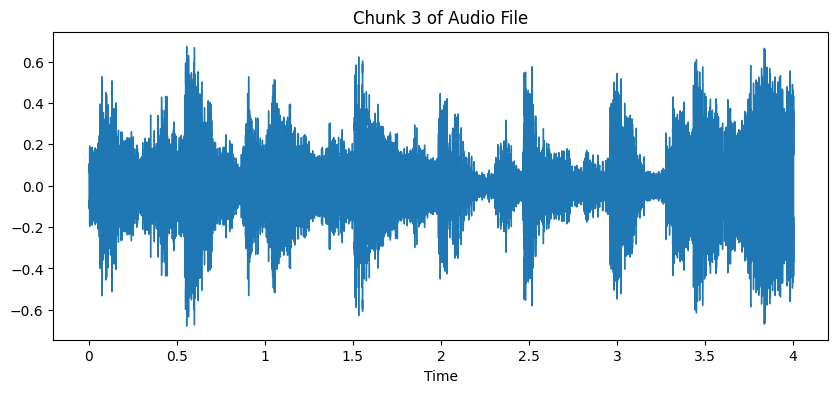

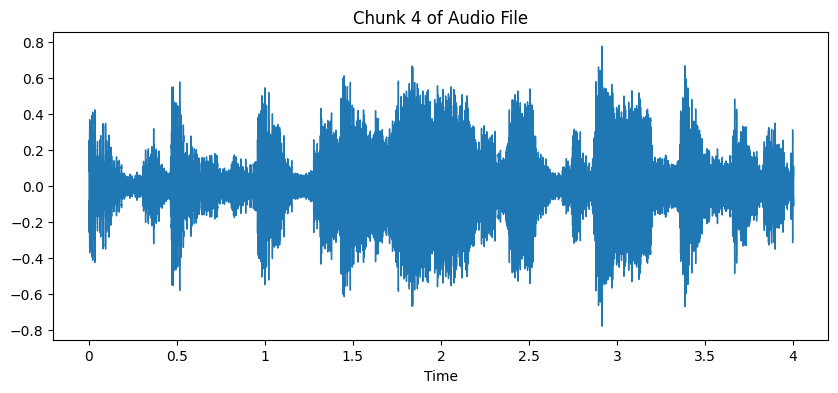

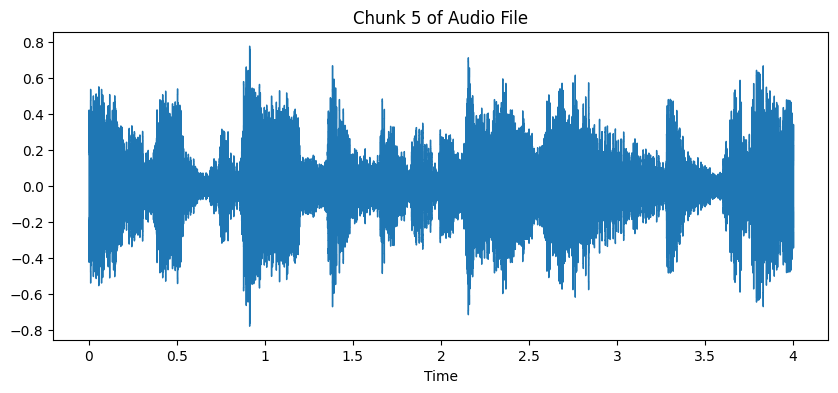

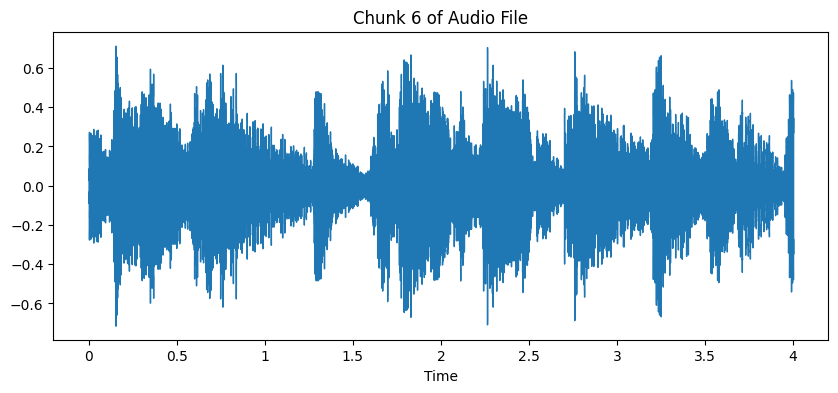

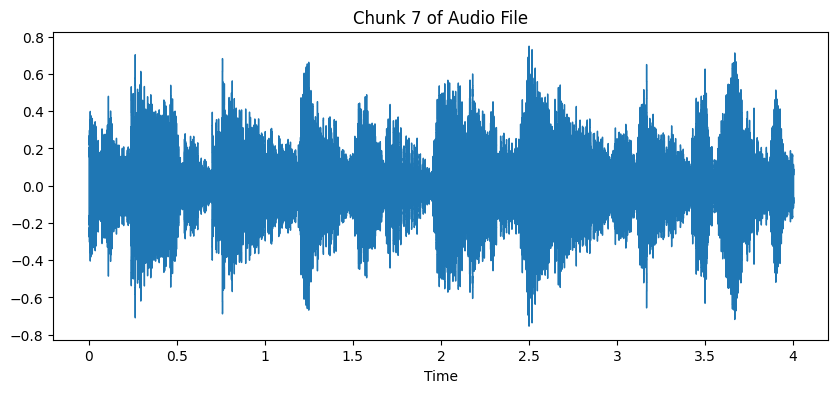

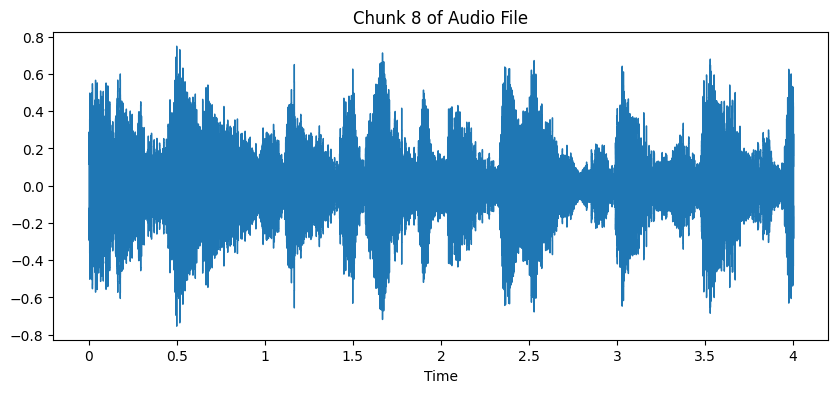

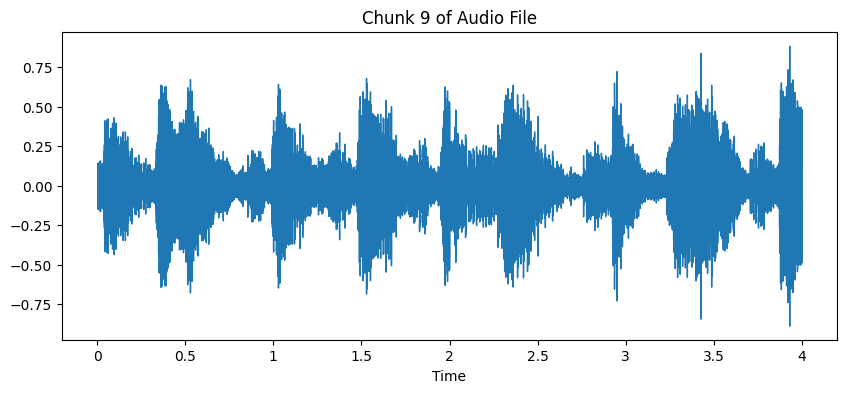

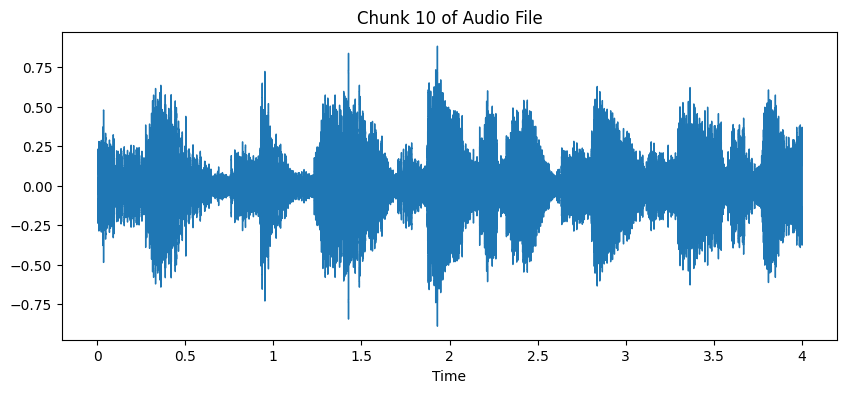

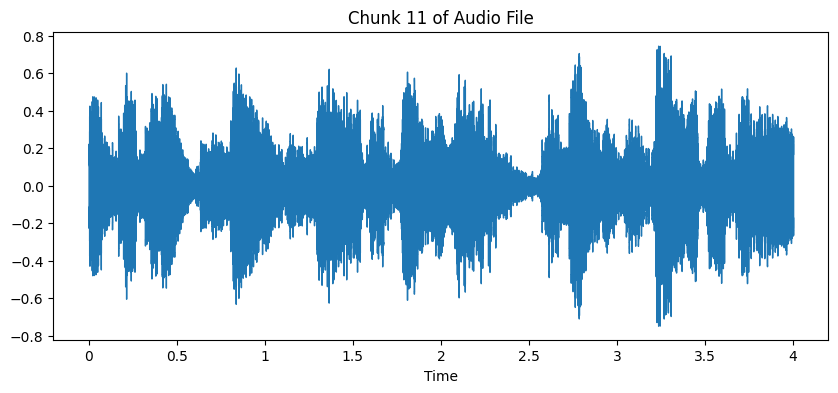

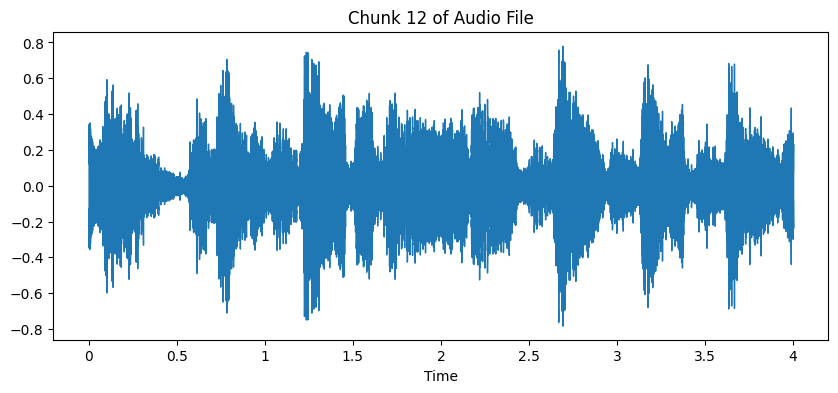

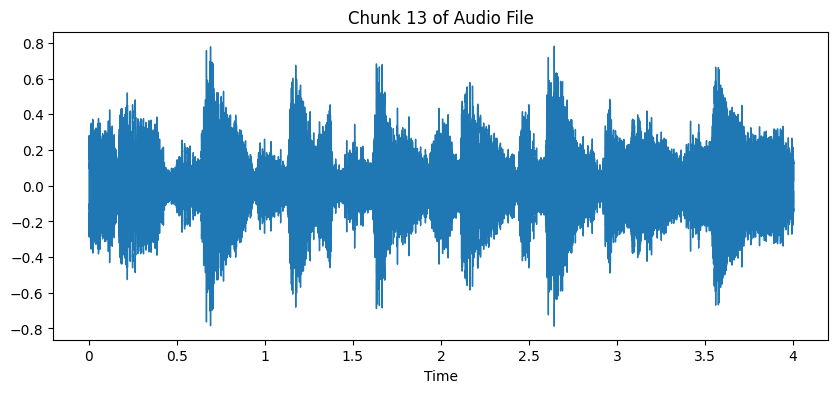

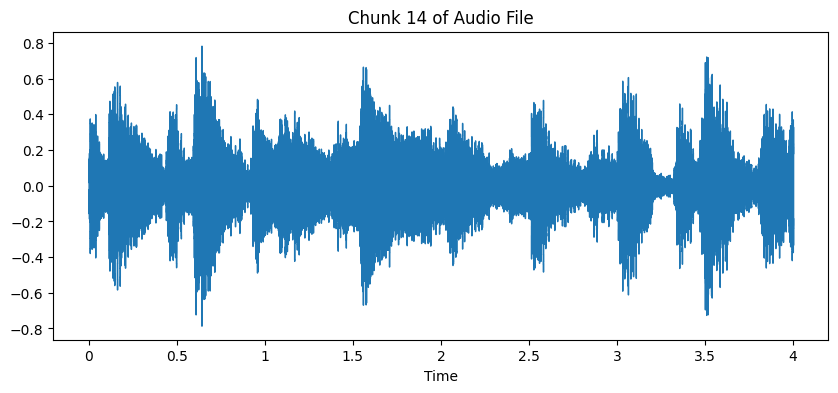

In [10]:
audio_path = "Data/genres_original/blues/blues.00000.wav"

s, sr = librosa.load(audio_path, sr=None)

chunk_size = 4 #seconds
overlap_duration = 2 #seconds

chunk_samples = chunk_size * sr
overlap_samples = overlap_duration * sr

# calculate the number of chunks
num_chunks = int(np.ceil(len(s) - chunk_samples)/(chunk_samples - overlap_samples)) + 1

# iterate over each chunk
for i in range(num_chunks):
    start = i * (chunk_samples - overlap_samples)
    end = start + chunk_samples

    # display the chunk
    chunk = s[start:end]
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(chunk, sr=sr)
    plt.title(f"Chunk {i+1} of Audio File")
    plt.show()

## Mel Spectorgram Visualization

In [11]:
def plot_mel_spectogram(s,sr):
    spectorgram = librosa.feature.melspectrogram(y=s,sr=sr)
    spectogram_db = librosa.power_to_db(spectorgram, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

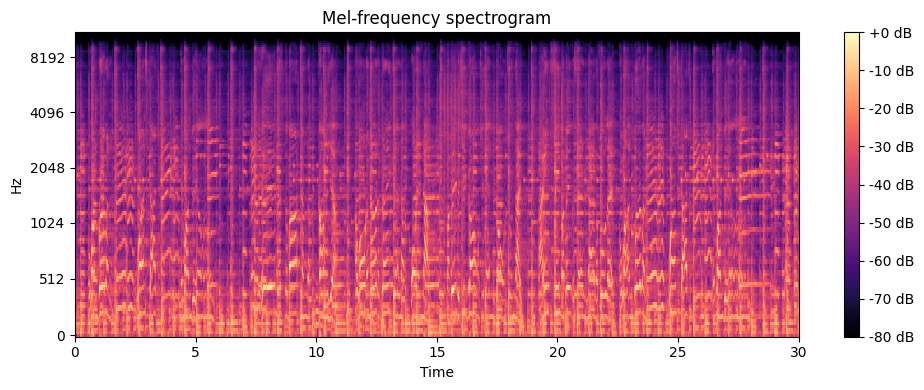

In [12]:
audio_path = "Data/genres_original/blues/blues.00000.wav"
s, sr = librosa.load(audio_path, sr=None)
plot_mel_spectogram(s, sr)

In [13]:
def plot_mel_spectogram_chunks(s,sr):

    chunk_size = 4 # seconds
    overlap_duration = 2

    # convert to samples
    chunk_samples = chunk_size * sr
    overlap_samples = overlap_duration * sr

    # calculate the number of chunks
    num_chunks = int(np.ceil(len(s) - chunk_samples) / (chunk_samples - overlap_samples)) + 1

    #iterate over each chunk
    for i in range(num_chunks):
        start = i * (chunk_samples - overlap_samples)
        end = start + chunk_samples

        # display the chunk
        chunk = s[start:end]
        plt.figure(figsize=(10, 4))
        spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel-frequency spectrogram of Chunk {i+1}')
        plt.tight_layout()
        plt.show()


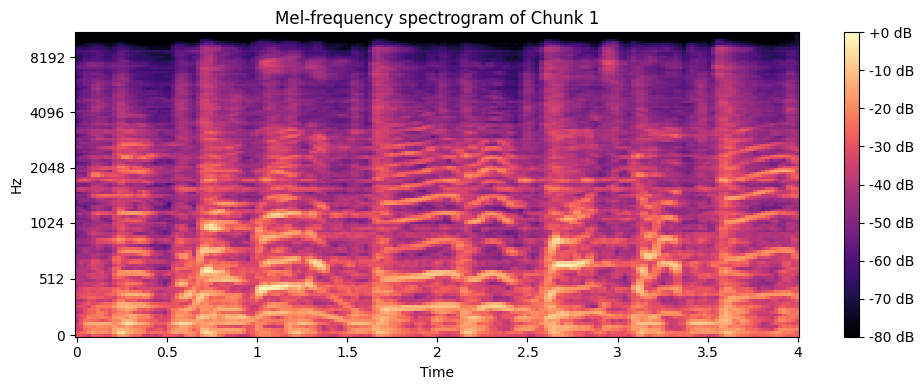

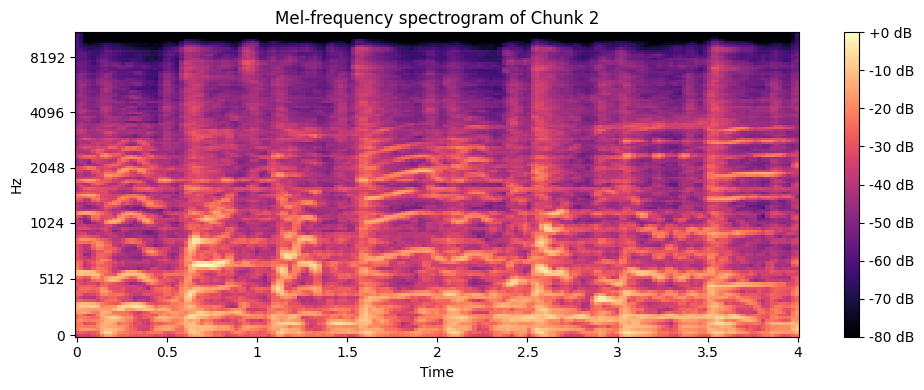

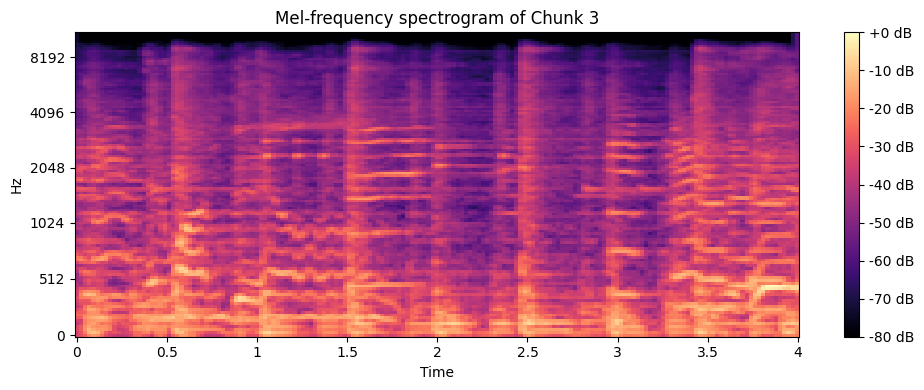

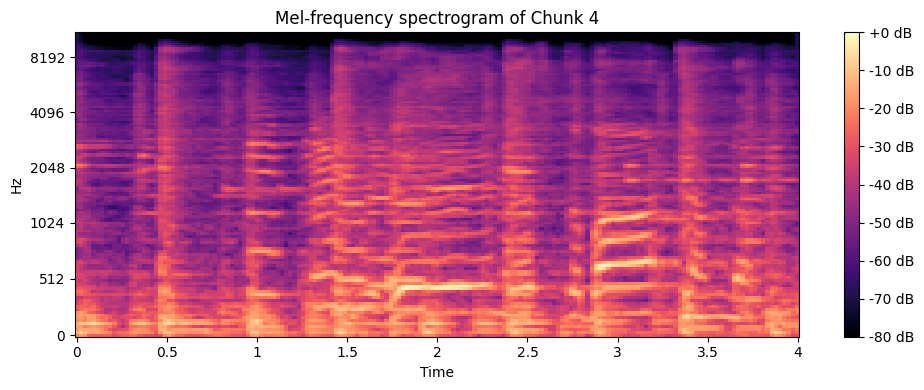

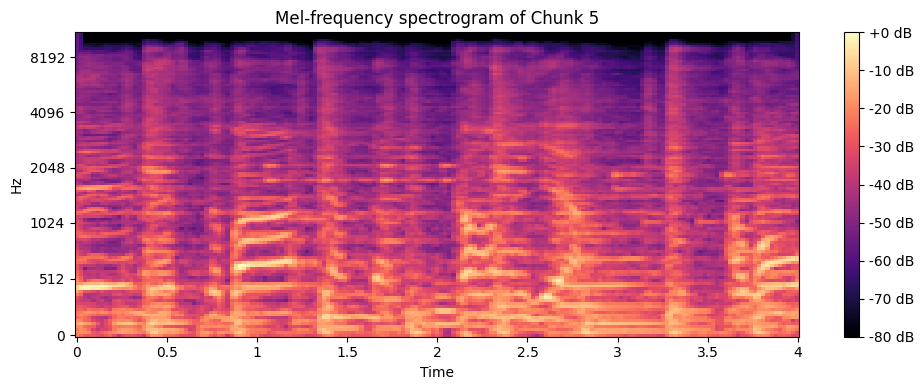

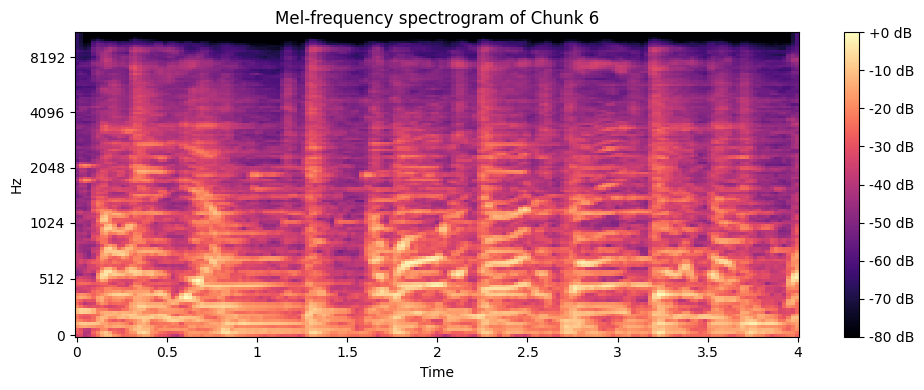

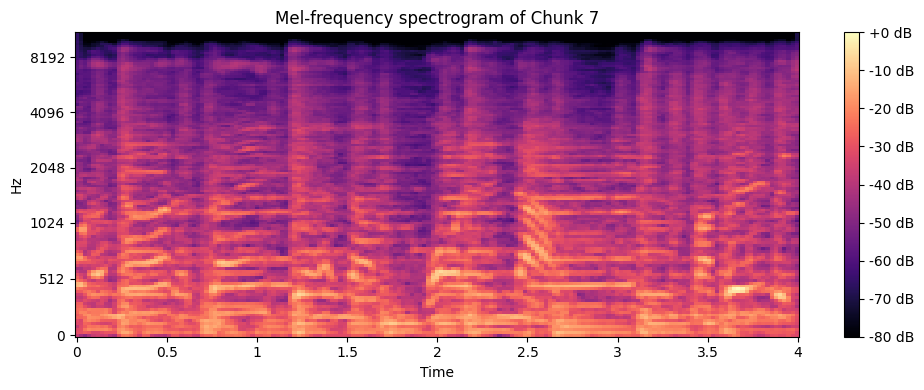

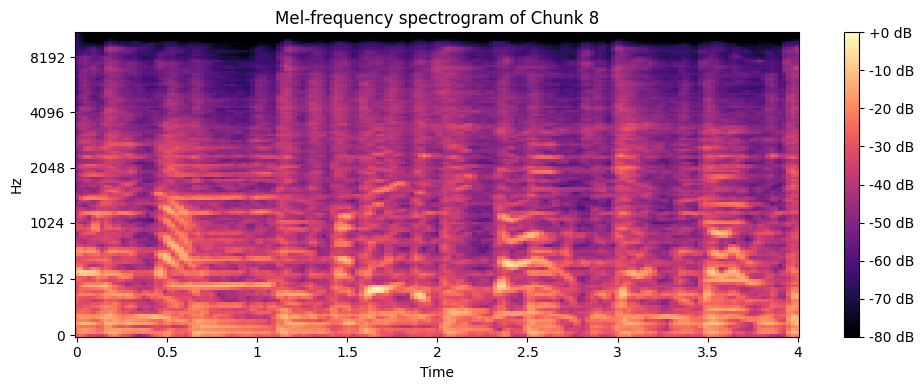

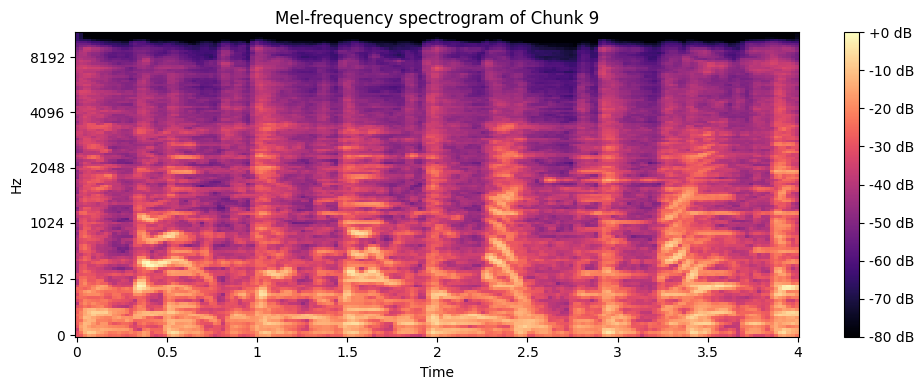

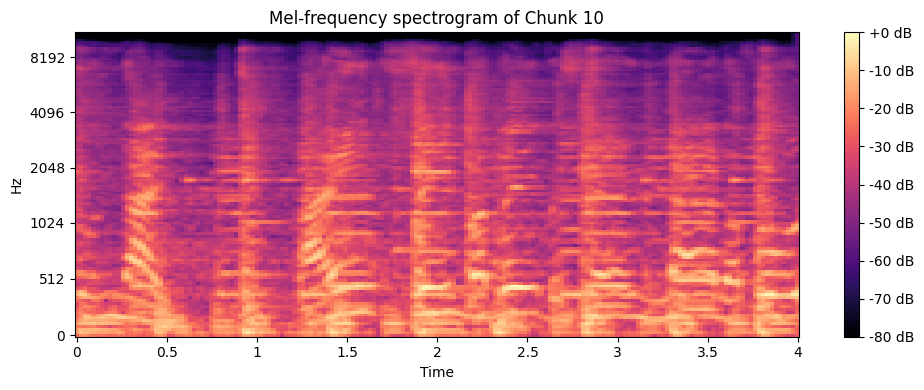

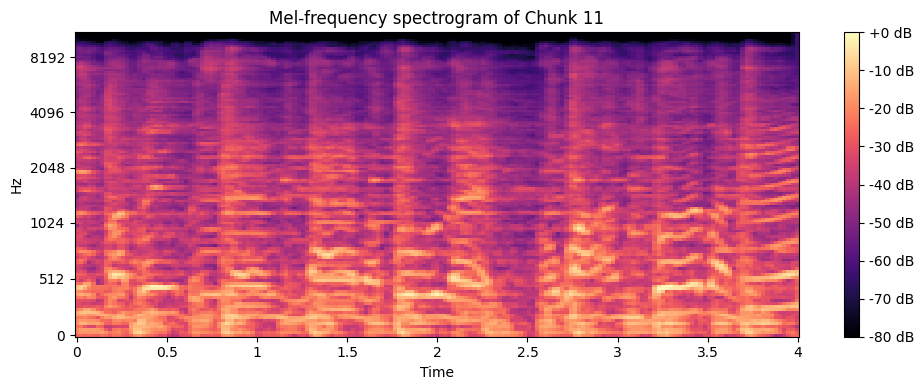

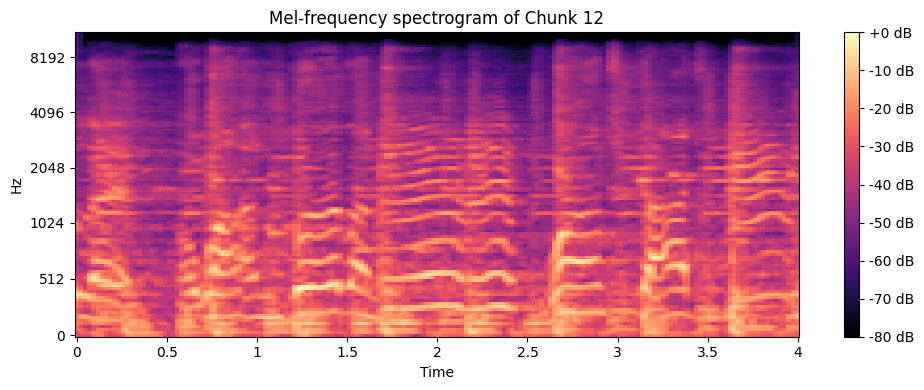

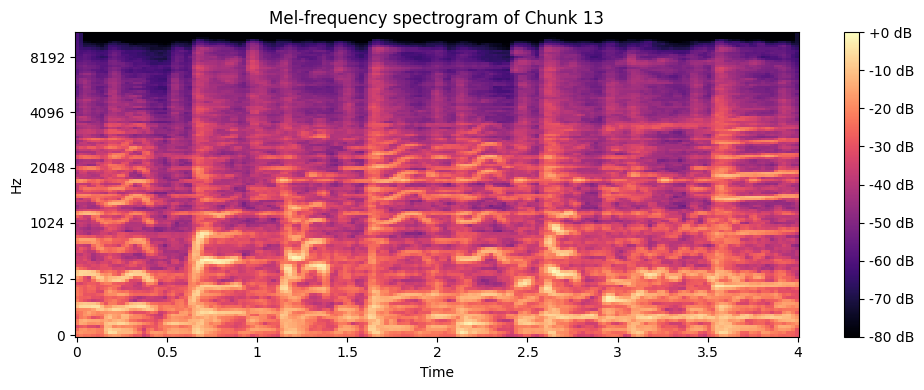

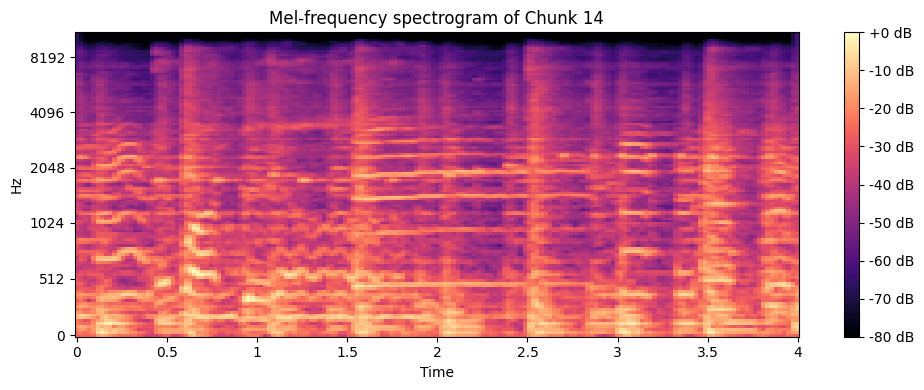

In [14]:
audio_path = "Data/genres_original/blues/blues.00000.wav"
s, sr = librosa.load(audio_path, sr=None)
plot_mel_spectogram_chunks(s,sr)

In [15]:
from tensorflow.image import resize
import os
import librosa
import numpy as np
from tensorflow.image import resize

# load and preprocess the all data

def load_and_preprocess_data(data_dir,classes, chunk_duration = 4, overlap_duration = 2, target_shape=(150,150)):
    data = []
    labels = []

    for label, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)

        for filename in os.listdir(class_dir):
            if filename.endswith(".wav"):
                file_path = os.path.join(class_dir, filename)
                try:
                    # Wrap librosa.load in a try-except block
                    s, sr = librosa.load(file_path, sr=None)

                    chunk_samples = chunk_duration * sr
                    overlap_samples = overlap_duration * sr

                    # Calculate the number of chunks. Ensure we don't get negative chunks.
                    # Also handle cases where audio length is less than chunk size.
                    audio_length = len(s)
                    if audio_length < chunk_samples:
                         num_chunks = 0 # Skip if audio is shorter than a chunk
                    else:
                        num_chunks = int(np.ceil((audio_length - chunk_samples) / (chunk_samples - overlap_samples))) + 1


                    # iterate over each chunk
                    for i in range(num_chunks):
                        start = i * (chunk_samples - overlap_samples)
                        end = start + chunk_samples
                        # Ensure end does not exceed audio length
                        if end > audio_length:
                            end = audio_length # Adjust end for the last potentially smaller chunk

                        chunk = s[start:end]

                        # Skip chunk if it's smaller than expected (can happen with last chunk)
                        # or if it's empty due to calculation errors with very short files
                        if len(chunk) < chunk_samples and i < num_chunks - 1:
                            continue # Skip if it's not the last chunk and is short
                        if len(chunk) == 0:
                             continue # Skip empty chunks

                        mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
                        # resize the mel spectrogram to the target shape
                        # Ensure the mel_spectrogram has a time dimension before resizing
                        if mel_spectrogram.shape[-1] == 0: # Check if the spectogram is empty (e.g., from empty chunk)
                           continue # Skip empty spectrograms

                        mel_spectrogram = resize(np.expand_dims(mel_spectrogram,axis=-1),target_shape)

                        # append the mel spectrogram and label to the data list
                        data.append(mel_spectrogram)
                        labels.append(label)
                except Exception as e:
                    print(f"Could not load or process file: {file_path} - Error: {e}")
                    # Continue to the next file if an error occurs
                    continue


    # The return statement should be outside the inner loop
    return np.array(data), np.array(labels)

In [16]:
#define your folder structure
data_dir = "Data/genres_original"
classes = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [17]:
data,labels = load_and_preprocess_data(data_dir,classes)

<ipython-input-15-0e55e9b0b111>:21: UserWarning: PySoundFile failed. Trying audioread instead.
  s, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not load or process file: Data/genres_original/jazz/jazz.00054.wav - Error: 


In [18]:
data.shape

(14975, 150, 150, 1)

In [19]:
labels.shape

(14975,)

In [20]:
print(data)

[[[[8.30226135e+00]
   [1.56790423e+00]
   [1.98250860e-01]
   ...
   [2.67385274e-01]
   [3.17374468e-01]
   [1.94850826e+00]]

  [[1.59826385e+02]
   [2.81842438e+02]
   [2.56864166e+02]
   ...
   [3.65168303e-01]
   [4.36112344e-01]
   [3.13233948e+00]]

  [[2.84636505e+02]
   [5.48968201e+02]
   [5.31313538e+02]
   ...
   [1.66693187e+00]
   [1.94305527e+00]
   [8.29833412e+00]]

  ...

  [[2.48731638e-04]
   [4.99523085e-05]
   [3.87578076e-08]
   ...
   [2.34133264e-08]
   [8.96298570e-06]
   [1.11353002e-04]]

  [[2.25036973e-04]
   [4.51811247e-05]
   [8.93925645e-09]
   ...
   [6.85425183e-09]
   [8.93135439e-06]
   [1.11444875e-04]]

  [[2.14141182e-04]
   [4.30217333e-05]
   [4.56186289e-09]
   ...
   [5.63179725e-09]
   [8.95567337e-06]
   [1.11698530e-04]]]


 [[[2.14636707e+00]
   [9.47388649e-01]
   [3.18547606e-01]
   ...
   [1.54650761e-02]
   [9.17398557e-02]
   [1.36731529e+00]]

  [[2.99876785e+01]
   [1.05776840e+02]
   [2.14593369e+02]
   ...
   [5.67427139e+01]
 

In [21]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels,num_classes = len(classes)) # Converting labels to one-hot encoding
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [22]:
print(labels)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [23]:
labels.shape

(14975, 10)

In [24]:
# # Flatten image data: (1400, 150, 150, 1) → (1400, 22500)
# data_reshaped = data.reshape(data.shape[0], -1)

# # Assuming labels shape is (1400, 10)
# combined = np.hstack((data_reshaped, labels))  # Final shape: (1400, 22510)

# # Save to CSV
# np.savetxt("data_with_labels.csv", combined, delimiter=",", fmt="%.4f")

## Loading data from csv file

In [25]:
# # Load the entire CSV
# loaded = np.loadtxt("data_with_labels.csv", delimiter=",")

# # Split into data and labels
# data = loaded[:, :-10]   # First 22500 columns
# labels = loaded[:, -10:] # Last 10 columns (one-hot labels)

# # Optional: reshape data back to original image shape
# data = data.reshape(-1, 150, 150, 1)


In [26]:
print(data.shape,labels.shape)

(14975, 150, 150, 1) (14975, 10)


## Splitting into Training and Test set

In [27]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,test_size=0.2,random_state=42)

## Building the Model

In [28]:
print(X_train.shape,Y_train.shape)

(11980, 150, 150, 1) (11980, 10)


In [29]:
model = tf.keras.models.Sequential()

In [30]:
X_train[0].shape

(150, 150, 1)

In [31]:
model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=X_train[0].shape))
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [33]:
model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [34]:
model.add(Dropout(0.3))

In [35]:
model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [36]:
model.add(Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=512,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [37]:
model.add(Dropout(0.3))

In [38]:
model.add(Flatten())

In [39]:
model.add(Dense(units=1200,activation='relu'))

In [40]:
model.add(Dropout(0.45))

In [41]:
#Output layer
model.add(Dense(units=len(classes),activation='softmax'))

In [42]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [44]:
#Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])

In [45]:
#Training Model
history = model.fit(X_train,Y_train,epochs=60,batch_size=32,validation_data=(X_test,Y_test),callbacks=[early_stop])

Epoch 1/60
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 119ms/step - accuracy: 0.1313 - loss: 2.2759 - val_accuracy: 0.1870 - val_loss: 2.1423
Epoch 2/60
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 76ms/step - accuracy: 0.1827 - loss: 2.1411 - val_accuracy: 0.2634 - val_loss: 2.0745
Epoch 3/60
375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - accuracy: 0.2408 - loss: 2.0797 - val_accuracy: 0.2938 - val_loss: 2.0236
Epoch 4/60
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.2900 - loss: 2.0065 - val_accuracy: 0.3753 - val_loss: 1.9409
Epoch 5/60
375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 77ms/step - accuracy: 0.3331 - loss: 1.9424 - val_accuracy: 0.4043 - val_loss: 1.8384
Epoch 6/60
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.3813 - loss: 1.8300 - val_accuracy: 0.4114 - val_loss: 1.6821
Epoch 7/60
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 79ms/step - accuracy: 0.3963 - loss: 1.6918 - val_accuracy: 0.4514 - val_loss: 1.5812
Epoch 8/60
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.4567 - loss: 1.5607 -

In [46]:
model.save("Trained_model.keras")

In [47]:
from google.colab import files
files.download('Trained_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
history.history

{'accuracy': [0.1507512480020523,
  0.20208680629730225,
  0.2502504289150238,
  0.2936560809612274,
  0.3466610908508301,
  0.3871452510356903,
  0.40868112444877625,
  0.45876461267471313,
  0.48931553959846497,
  0.5128547549247742,
  0.5358096957206726,
  0.5506677627563477,
  0.572120189666748,
  0.5858097076416016,
  0.5979132056236267,
  0.6137729287147522,
  0.6257095336914062,
  0.6383973360061646,
  0.651669442653656,
  0.657429039478302,
  0.6791318655014038,
  0.6815525889396667,
  0.6973288655281067,
  0.697746217250824,
  0.7030050158500671,
  0.7156093716621399,
  0.7222036719322205,
  0.7294657826423645,
  0.7341402173042297,
  0.750751256942749,
  0.7527545690536499,
  0.7586811184883118,
  0.7682804465293884,
  0.7723706364631653,
  0.7792988419532776,
  0.7824707627296448,
  0.7863940000534058,
  0.7954924702644348,
  0.7929883003234863,
  0.8050917983055115,
  0.807262122631073,
  0.8141903281211853,
  0.8222871422767639,
  0.8241235613822937,
  0.8283806443214417,


In [49]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(history.history,f)

In [50]:
from google.colab import files
files.download('training_hist.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
X_train

array([[[[4.82450447e+01],
         [1.51552620e+01],
         [6.32521915e+00],
         ...,
         [3.85338449e+00],
         [4.61355829e+00],
         [2.12597251e+00]],

        [[1.60108612e+02],
         [1.26405624e+02],
         [8.56978149e+01],
         ...,
         [9.35671139e+00],
         [1.31481247e+01],
         [1.06956549e+01]],

        [[4.48919159e+02],
         [7.77570801e+02],
         [6.48938416e+02],
         ...,
         [2.26802273e+01],
         [4.66932144e+01],
         [5.02218781e+01]],

        ...,

        [[2.01346958e-03],
         [4.10486711e-04],
         [2.86547674e-07],
         ...,
         [1.62158912e-07],
         [7.76646721e-06],
         [9.60125108e-05]],

        [[2.00457498e-03],
         [4.08333493e-04],
         [2.07422577e-08],
         ...,
         [2.93889002e-08],
         [7.67782512e-06],
         [9.55732248e-05]],

        [[2.00162572e-03],
         [4.07713407e-04],
         [6.11541218e-09],
         ...,
 

In [52]:
#Reloading model variable
model = tf.keras.models.load_model("Trained_model.keras")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,547,376 (82.20 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,364,918 (54.80 MB)

In [53]:
#Reloading Training history
import json
with open("training_hist.json",'r') as json_file:
    training_history_data = json.load(json_file)

In [54]:
training_history_data.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [55]:
#Model evaluation on Training set
train_loss,train_accuracy = model.evaluate(X_train,Y_train)

375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9382 - loss: 0.2180


In [56]:
train_loss,train_accuracy

(0.23022134602069855, 0.933639407157898)

In [57]:
#Model evaluation on Validation set
val_loss,val_accuracy = model.evaluate(X_test,Y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8272 - loss: 0.5436


In [58]:
val_loss,val_accuracy

(0.5537583231925964, 0.8193656206130981)

In [59]:
training_history_data['val_loss']

[2.1422677040100098,
 2.0745222568511963,
 2.0235702991485596,
 1.9408740997314453,
 1.838423728942871,
 1.682070016860962,
 1.5812058448791504,
 1.4939591884613037,
 1.4181054830551147,
 1.3431193828582764,
 1.3579113483428955,
 1.2652603387832642,
 1.1883944272994995,
 1.1580907106399536,
 1.1218602657318115,
 1.0492134094238281,
 1.050246238708496,
 0.9982848763465881,
 0.9670459032058716,
 0.97068190574646,
 0.9377769827842712,
 0.9058142900466919,
 0.8777645230293274,
 0.9030843377113342,
 0.8545988202095032,
 0.8883118033409119,
 0.8154585361480713,
 0.808178186416626,
 0.7903695106506348,
 0.7564833760261536,
 0.7588373422622681,
 0.7446399927139282,
 0.7310689687728882,
 0.7234843969345093,
 0.6914018392562866,
 0.6956167817115784,
 0.6900386810302734,
 0.6901906132698059,
 0.6690398454666138,
 0.7131365537643433,
 0.6555014848709106,
 0.6485285758972168,
 0.6508121490478516,
 0.6610186100006104,
 0.6502367854118347,
 0.5970297455787659,
 0.6088454127311707,
 0.6062844395637512

## Accuracy and loss Visualization

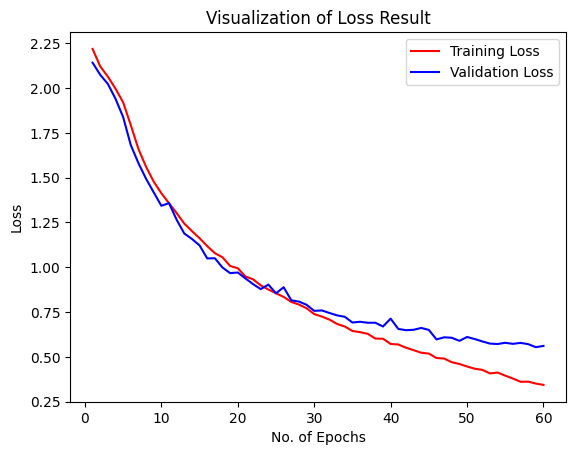

In [60]:
#Visualization of Loss
# Get the actual number of epochs trained
num_epochs_trained = len(training_history_data['loss'])
epochs = [i for i in range(1, num_epochs_trained + 1)]

plt.plot(epochs,training_history_data['loss'],label="Training Loss",color='red')
plt.plot(epochs,training_history_data['val_loss'],label="Validation Loss",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

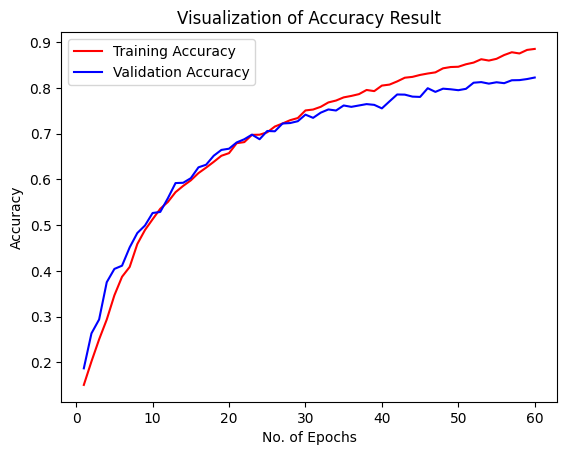

In [61]:
#Visualization of Accuracy
# Use the same calculated number of epochs for the accuracy plot
plt.plot(epochs,training_history_data['accuracy'],label="Training Accuracy",color='red')
plt.plot(epochs,training_history_data['val_accuracy'],label="Validation Accuracy",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()

In [62]:
X_test.shape

(2995, 150, 150, 1)

In [63]:
y_pred = model.predict(X_test)
y_pred

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


array([[2.5132655e-11, 2.1093485e-12, 2.9250569e-12, ..., 9.9991381e-01,
        4.9777263e-06, 1.9817461e-08],
       [2.4961905e-06, 2.6816991e-08, 2.0641866e-07, ..., 5.3242951e-07,
        6.7049064e-09, 1.6348149e-03],
       [5.0717257e-11, 1.1187848e-14, 2.8393881e-13, ..., 1.1958110e-07,
        1.2677911e-13, 8.5490183e-06],
       ...,
       [8.7980008e-01, 4.3173186e-02, 9.5243478e-04, ..., 1.1391921e-04,
        1.5142055e-04, 6.9906772e-04],
       [1.0758443e-04, 9.8431522e-01, 1.6838594e-04, ..., 3.1527173e-04,
        1.1451199e-04, 4.8451239e-04],
       [7.6550528e-02, 1.3621716e-02, 1.4793732e-02, ..., 2.4666359e-01,
        1.8595403e-01, 1.3272153e-01]], dtype=float32)

In [64]:
y_pred.shape

(2995, 10)

In [65]:
predicted_categories = np.argmax(y_pred,axis=1)
predicted_categories

array([7, 6, 6, ..., 0, 1, 7])

In [66]:
true_categories = np.argmax(Y_test,axis=1)
true_categories

array([7, 6, 6, ..., 0, 1, 4])

In [67]:
len(classes)

10

In [68]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(true_categories,predicted_categories)
# Precision Recall F1score
print(classification_report(true_categories,predicted_categories,target_names=classes))

              precision    recall  f1-score   support

       blues       0.79      0.87      0.83       302
   classical       0.87      0.93      0.90       298
     country       0.80      0.60      0.69       317
       disco       0.87      0.84      0.85       312
      hiphop       0.88      0.86      0.87       277
        jazz       0.80      0.87      0.84       311
       metal       0.88      0.94      0.91       302
         pop       0.79      0.78      0.78       289
      reggae       0.82      0.86      0.84       296
        rock       0.68      0.64      0.66       291

    accuracy                           0.82      2995
   macro avg       0.82      0.82      0.82      2995
weighted avg       0.82      0.82      0.82      2995



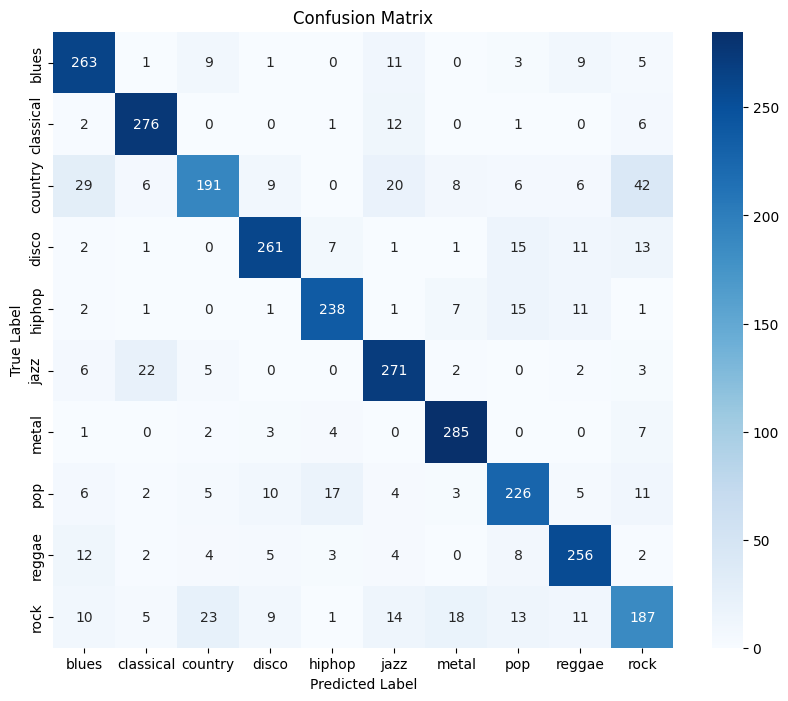

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already computed:
# true_categories: numpy array of true category indices
# predicted_categories: numpy array of predicted category indices
# classes: list of class names

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()